In [125]:
import sys
sys.path.append('/Automatic-Circuit-Discovery/')
sys.path.append('..')
import os
import re
import json
import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')

from acdc.docstring.utils import get_docstring_subgraph_true_edges

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

cpu


# Get experiment to find edges

In [126]:
from acdc.docstring.utils import get_all_docstring_things
from acdc.TLACDCExperiment import TLACDCExperiment
all_docstring_items = get_all_docstring_things(num_examples=40, seq_len=5, device=device, metric_name='docstring_metric', correct_incorrect_wandb=False)

model = all_docstring_items.tl_model
test_metrics = all_docstring_items.test_metrics['docstring_metric']
test_data = all_docstring_items.test_data
test_patch_data = all_docstring_items.test_patch_data

exp = TLACDCExperiment(
            model=model,
            threshold=0,
            ds=test_data,
            ref_ds=test_patch_data,
            metric=test_metrics,
            run_name=None,
        )
exp.model.reset_hooks()
exp.setup_model_hooks(
    add_sender_hooks=True,
    add_receiver_hooks=True,
    doing_acdc_runs=False
)

del all_docstring_items

Loaded pretrained model attn-only-4l into HookedTransformer
Moving model to device:  cpu


self.current_node=TLACDCInterpNode(blocks.3.hook_resid_post, [:])


# All edges and ground truth eges

In [134]:
def convert_to_torch_index(index_list):
    return ''.join(['None' if i == ':' else i for i in index_list])

def get_all_edges(exp):
    all_edges = set()
    for child_name in exp.corr.edges:
        for child_idx in exp.corr.edges[child_name]:
            child_idx_converted = convert_to_torch_index(str(child_idx))
            for parent_name in exp.corr.edges[child_name][child_idx]:
                for parent_idx in exp.corr.edges[child_name][child_idx][parent_name]:
                    parent_idx_converted = convert_to_torch_index(str(parent_idx))
                    all_edges.add(f'{parent_name}{parent_idx_converted}{child_name}{child_idx_converted}')
    return all_edges

all_edges = get_all_edges(exp)

In [135]:
# EDGES ground truth
true_edges_tuples = get_docstring_subgraph_true_edges()
true_edges = set()
replace_parens = lambda tup: str(tup).replace('(', '[').replace(')', ']').replace('[None,]', '[None]')

for child_name, child_idx, parent_name, parent_idx in true_edges_tuples:
    true_edges.add(f'{parent_name}{replace_parens(parent_idx)}{child_name}{replace_parens(child_idx)}')

In [136]:
# pruned_edges, true_edges should all be in all_edges
def test_all_edges(pruned_edges, verbose=False):
    for pruned_edge in pruned_edges:
        if not pruned_edge in all_edges:
            print(pruned_edge)
    if verbose:
        print('Pruned edge test complete')
    for true_edge in true_edges:
        if not true_edge in all_edges:
            print(true_edge)
    if verbose:
        print('True edge test complete')

In [247]:
with open('./res/docstring_absval_edge/present_edge_attrs.json', 'r') as f:
    present_edge_attrs = json.load(f)

with open('./res/docstring_absval_edge/num_passes.json', 'r') as f:
    num_passes = json.load(f)

data = []
for pp_thresh in present_edge_attrs.keys():
    for acdc_thresh in present_edge_attrs[pp_thresh].keys():
        # Read set of present edges after applying ACDC++ and ACDC
        present_edges = set()
        for (child_name, child_idx, parent_name, parent_idx, attr) in present_edge_attrs[pp_thresh][acdc_thresh]: # sorry, messed up parent child indexing convention
            present_edges.add(f'{parent_name}{replace_parens(parent_idx)}{child_name}{replace_parens(child_idx)}')
            # present_edges.add(f'{parent_name}{parent_idx}{child_name}{child_idx}')
        test_all_edges(present_edges)

        # Calc stats
        tp = len(present_edges.intersection(true_edges))
        tn = len((all_edges - present_edges).intersection(all_edges - true_edges))
        fp = len(present_edges - true_edges)
        fn = len(true_edges - present_edges)

        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        fpr = 1 - tnr
        fnr = 1 - tpr

        pp_thr = np.round(float(pp_thresh), 3)
        acdc_thr = np.round(float(acdc_thresh), 3)
        pp_thr_str = pp_thresh[:5]
        acdc_thr_str = acdc_thresh[:5]
        youdens = np.round(tpr-fpr, 3)
        passes = num_passes[pp_thresh][acdc_thresh]

        data.append([pp_thr, acdc_thr, pp_thr_str, acdc_thr_str, tpr, tnr, fpr, fnr, youdens, passes])

df = pd.DataFrame(data, columns=['pp_thresh', 'acdc_thresh', 'pp_thresh_str', 'acdc_thresh_str', 'tpr', 'tnr', 'fpr', 'fnr', 'youdens', 'num_passes'])
df.head()

,pp_thresh,acdc_thresh,pp_thresh_str,acdc_thresh_str,tpr,tnr,fpr,fnr,youdens,num_passes
0,0.015,0.034,0.015,0.033,0.702703,0.955432,0.044568,0.297297,0.658,216
1,0.015,0.048,0.015,0.047,0.648649,0.968663,0.031337,0.351351,0.617,182
2,0.015,0.062,0.015,0.062,0.621622,0.977716,0.022284,0.378378,0.599,157
3,0.015,0.077,0.015,0.076,0.621622,0.981894,0.018106,0.378378,0.604,150
4,0.015,0.091,0.015,0.090,0.621622,0.989554,0.010446,0.378378,0.611,140


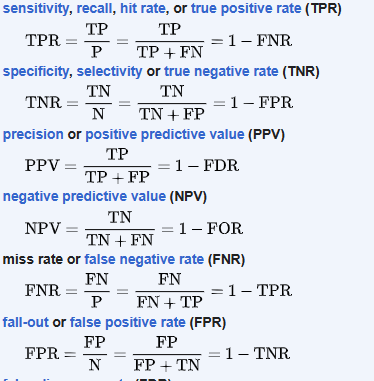

# Youdens J metric (TPR - FPR)

In [248]:
ydf = df.pivot(index='acdc_thresh_str', columns='pp_thresh_str')['youdens']

In [249]:
fig = px.imshow(
    ydf,
    text_auto=True,
    color_continuous_scale="RdBu",
    labels=dict(x="Attribution Patching threshold", y="ACDC threshold"),
    )

fig.update_xaxes(tickangle = 45)
fig.update_yaxes(ticksuffix = '  ')
fig.show()

# Num passes vs Youdens metric

In [243]:
ndf = df.copy()
ndf["pp_thresh_over_0.04"] = ndf["pp_thresh"] > 0.04
ndf = df[["num_passes", "youdens"]].sort_values("num_passes")
ndf.head()

,num_passes,youdens
31,63,0.293
61,85,0.857
62,85,0.857
63,85,0.857
60,88,0.882


In [254]:
px.scatter(ndf, x="num_passes", y="youdens", color="pp_thresh_over_0.04")

# ACDC num passes over Attribution Patching threshold

In [265]:
fig = px.box(df, x="pp_thresh", y="num_passes")

fig.update_xaxes(
    title="attribution patching threshold"
)